In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Embedding, BatchNormalization, 
                                     Flatten, Conv1D, SpatialDropout1D, 
                                     GlobalAveragePooling1D, GlobalMaxPooling1D,
                                     LSTM, GRU, SimpleRNN, Bidirectional)
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_text(file_name):
    t = open(file_name, 'r')
    text = t.read()
    text = text.replace('\n', '')
    return text

In [ ]:
# Создаем классы
class_name = ['Братья Стругацкие', 'К. Саймак', 'М. Фрай', 'М. Булгаков', 'О. Генри', 'Р. Брэдберри']
n_classes = len(class_name)
n_classes

6

In [ ]:
train_text = []
test_text = []

for i in class_name:
    for j in os.listdir('/content/drive/MyDrive/UAI/Data_CSV/texts/'):
        if i in j:
            if 'Обучающая' in j:
                train_text.append(read_text('/content/drive/MyDrive/UAI/Data_CSV/texts/' + j))
                print(j, 'Добавлен в обучающую выборку')
            if 'Тестовая' in j:
                test_text.append(read_text('/content/drive/MyDrive/UAI/Data_CSV/texts/' + j))
                print(j, 'Добавлен в Тестовую выборку')
    print()

(Братья Стругацкие) Обучающая.txt Добавлен в обучающую выборку
(Братья Стругацкие) Тестовая.txt Добавлен в Тестовую выборку

(К. Саймак) Обучающая.txt Добавлен в обучающую выборку
(К. Саймак) Тестовая.txt Добавлен в Тестовую выборку

(М. Фрай) Обучающая.txt Добавлен в обучающую выборку
(М. Фрай) Тестовая.txt Добавлен в Тестовую выборку

(М. Булгаков) Обучающая.txt Добавлен в обучающую выборку
(М. Булгаков) Тестовая.txt Добавлен в Тестовую выборку

(О. Генри) Тестовая.txt Добавлен в Тестовую выборку
(О. Генри) Обучающая.txt Добавлен в обучающую выборку

(Р. Брэдберри) Обучающая.txt Добавлен в обучающую выборку
(Р. Брэдберри) Тестовая.txt Добавлен в Тестовую выборку



In [ ]:
# Преобразовываем текстовые данные в цифровые
max_word_count = 50000   # Берем 50000 для дальнешего разбиения на сотни
tokenizer = Tokenizer(num_words=max_word_count, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(train_text)
items = list(tokenizer.word_index.items())

In [ ]:
items[2]

('в', 3)

In [ ]:
train_word_indexes = tokenizer.texts_to_sequences(train_text)
test_word_indexes = tokenizer.texts_to_sequences(test_text)

In [ ]:
# Ищем редко встречающиеся слова
rare_words = 2
low_rare_words = [w for w, v in tokenizer.word_counts.items() if v < rare_words]

print(low_rare_words)

['преисподней1ну', 'выжжена', 'сетями', 'полевая', 'снятая', 'крестец', 'окоркам', 'выволоклись', 'огородные', 'обомлели', 'голенищу', 'навоевали', 'воинская', 'бригадные', 'интенданты', 'ходячее', 'удобрение', 'смазка', 'штыка', 'гуляючи', 'маскировочный', 'шесте', 'вьюках', 'раненом', 'драном', 'обгоревшем', 'маскировочном', 'опаленными', 'егерей', 'дигга', 'опалило', 'смола', 'отступаю', 'бронеходах', 'дикобразами', 'бредил', 'затянулись', 'вцепляясь', 'запрокинутого', 'рокаде', 'бомбовым', 'расчищали', 'лезущих', 'заскорузлую', 'беспросветное', 'околицу', 'съехавший', 'завалившийся', 'бортовым', 'дохлый', 'отрыли', 'околицей', 'посеяно', 'окопов', 'хоботы', 'увязнув', 'селу', 'лафете', 'щепочкой', 'рассерженные', 'изрыгал', 'выронивши', 'пикнули', 'мордам', 'бакенбардах', 'прожилках', 'захватанное', 'гепардом', 'приуменьшился', 'седенький', 'росточка', 'подкреплений', 'пулеметах', 'ракетометах', 'потертостями', 'грыжей', 'полированная', 'тросточка', 'бронепехоты', 'крысоеда', 'гого

In [ ]:
# Удаляем редко встречающиеся слова
for w in low_rare_words:
    del tokenizer.word_index[w]
    del tokenizer.word_docs[w]
    del tokenizer.word_counts[w]

In [ ]:
train_word_indexes = train_word_indexes
test_word_indexes = test_word_indexes

In [ ]:
# Создаем функции для формирования выборок (ширина, шаг)
def get_set_from_indexes(word_indexes, w_len, step):
    X_sample = []
    words_len = len(word_indexes)
    index = 0

    while(index + w_len <= words_len):
        X_sample.append(word_indexes[index:index + w_len])
        index += step

    return X_sample

In [ ]:
# Из двух листов индексов двух классов формируем обучающую и проверочную выборки
def create_sets_multi_classes(word_indexes, w_len, step):
    n_classes = len(word_indexes)
    classes_X_samples = []
    for wI in word_indexes:
        classes_X_samples.append(get_set_from_indexes(wI, w_len, step))

# Формируем общий X_samples, y_samples
    X_samples = []
    y_samples = []

    for n in range(n_classes):
        x_t = classes_X_samples[n]
        for i in range(len(x_t)):
            X_samples.append(x_t[i])
            y_samples.append(utils.to_categorical(n, n_classes))

    X_samples = np.array(X_samples)
    y_samples = np.array(y_samples)

    return (X_samples, y_samples)

In [ ]:
# Задаем параметры
w_len = 1000
step = 100

In [ ]:
# Создаем обучающую и тестовую выборки
X_train, y_train = create_sets_multi_classes(train_word_indexes, w_len, step)
X_test, y_test = create_sets_multi_classes(test_word_indexes, w_len, step)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(17634, 1000)
(17634, 6)
(6683, 1000)
(6683, 6)


In [ ]:
# Пример оригинального отрезка текста
X_train[1]

array([  132,  3034, 18821,     2,  2831,   108,   521,     4,  5977,
          12,    72, 18822,    12,    72, 32330,    46,    12,    72,
          32, 39792,     7,  1557,   774,     1,     1,     1,  7259,
           1,     8,  6476,  4585, 18823,  3662,    83,  4461,     3,
       27503,  2341, 32331,  2734,  5550,  2873,  4236, 39793,     3,
       27504,     1,     7,  3359, 21083,    17,   369,    31,    86,
       32332,  2874,   386,     2, 21084,    17,  7570,    33,  3815,
           2,  4857,     1,   100,    68,  3093,    13,  5192,    55,
           4, 39794,  2201,     6,    12,     3,   279, 15501,     2,
        3741,     1,   137,    12,   950,   652,     1,     5,    51,
       17003, 15502,    67,     1,     9,  3360,   569,   317,  1192,
        3501,     2,   166,   768,    11,  1606,  5030,    16,    64,
        1409,    67,   769,     1,    35,    36, 39795,  1441,  1199,
          16, 21085,    20,    68,    16,    75,    60,  3093,   135,
        2202,  4857,

In [ ]:
model = Sequential([
                    Embedding(max_word_count, 64, input_length=w_len),
                    SpatialDropout1D(0.6),
                    BatchNormalization(),
                    LSTM(64, return_sequences=True),
                    Dropout(0.4),
                    BatchNormalization(),
                    Dense(64, activation='relu'),
                    #SpatialDropout1D(0.6),
                    Dropout(0.6),
                    BatchNormalization(),
                    Flatten(),
                    Dense(6, activation='softmax')
                   ])

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 64)          3200000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1000, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 64)          256       
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 64)          33024     
_________________________________________________________________
dropout (Dropout)            (None, 1000, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 64)          256       
_________________________________________________________________
dense (Dense)                (None, 1000, 64)          4

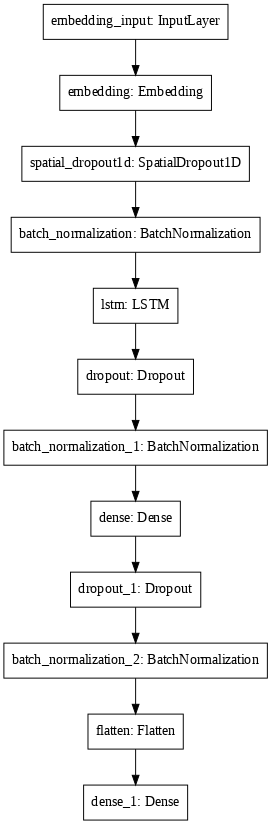

In [ ]:
model.summary()
print('_ _ _ _ _ MODEL _ _ _ _ _ ')
plot_model(model, dpi=70)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
276/276 [==============================] - 57s 84ms/step - loss: 1.5749 - accuracy: 0.5824 - val_loss: 13.0688 - val_accuracy: 0.2949
Epoch 2/50
276/276 [==============================] - 23s 82ms/step - loss: 0.1596 - accuracy: 0.9692 - val_loss: 17.3370 - val_accuracy: 0.3504
Epoch 3/50
276/276 [==============================] - 23s 82ms/step - loss: 0.1646 - accuracy: 0.9763 - val_loss: 6.2746 - val_accuracy: 0.6792
Epoch 4/50
276/276 [==============================] - 22s 81ms/step - loss: 0.1496 - accuracy: 0.9798 - val_loss: 6.4738 - val_accuracy: 0.6313
Epoch 5/50
276/276 [==============================] - 22s 81ms/step - loss: 0.1382 - accuracy: 0.9813 - val_loss: 12.1207 - val_accuracy: 0.5881
Epoch 6/50
276/276 [==============================] - 22s 81ms/step - loss: 0.1553 - accuracy: 0.9828 - val_loss: 10.1279 - val_accuracy: 0.6180
Epoch 7/50
276/276 [==============================] - 22s 81ms/step - loss: 0.1601 - accuracy: 0.9839 - val_loss: 13.1719 - val_accu

In [ ]:
# точность модели Embedding+LSTM
normal_accuracy = model.evaluate(X_test, y_test)[1]
normal_accuracy

209/209 [==============================] - 4s 18ms/step - loss: 15.3868 - accuracy: 0.5589


0.5588807463645935

In [ ]:
# максимальная точность  и ошибка на обучающей и проверочной выборе
print(f'Максимальная точность обучающей выборки: {max(history.history["accuracy"])} \
\nМинимальная ошибка на обучающей выборе: {min(history.history["loss"])} \
\nМаксимальная точность проверочной выборки: {max(history.history["val_accuracy"])} \
\nМинимальная ошибка на проверочной выборе: {min(history.history["val_loss"])}')

Максимальная точность обучающей выборки: 0.9939888715744019 
Минимальная ошибка на обучающей выборе: 0.04820558428764343 
Максимальная точность проверочной выборки: 0.6791859865188599 
Минимальная ошибка на проверочной выборе: 6.274635314941406


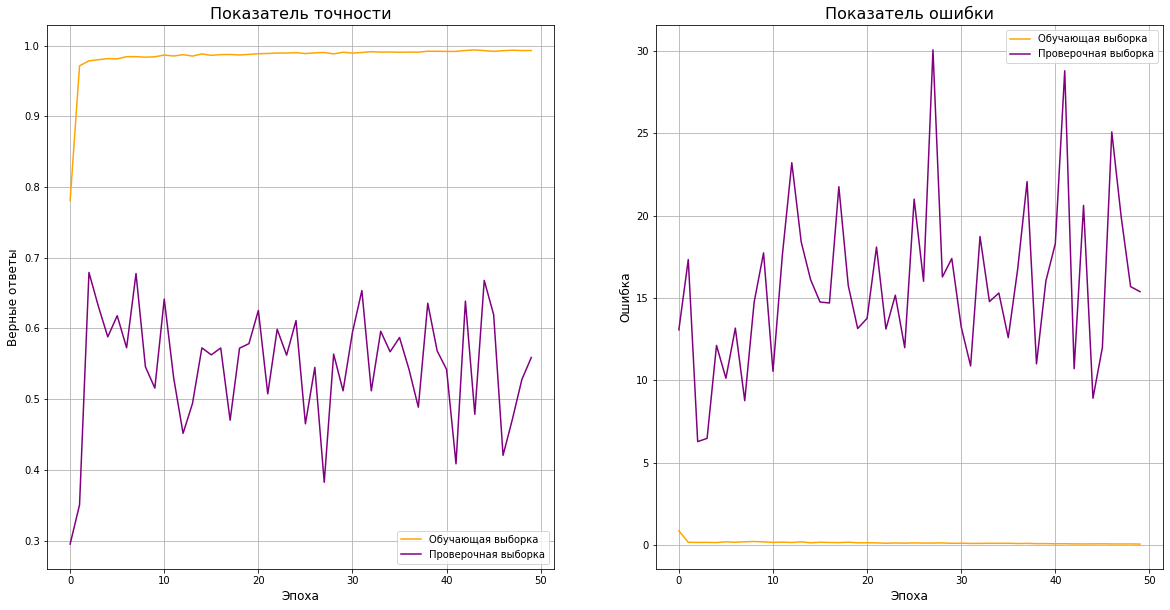

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='orange', label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], color='purple', label='Проверочная выборка')
plt.title('Показатель точности', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Верные ответы', fontsize=12)
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='orange', label='Обучающая выборка')
plt.plot(history.history['val_loss'], color='purple', label='Проверочная выборка')
plt.title('Показатель ошибки', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Ошибка', fontsize=12)
plt.legend()
plt.grid()

plt.show()

In [ ]:
# Тестовая выборка
def create_test_multi_classes(word_indexes, w_len, step): # функция принимает последовательность индексов, размер окна, шаг окна

    n_classes = len(word_indexes)
    X_test_classes = []
    X_test_array = []
    for wI in word_indexes:
        sample = (get_set_from_indexes(wI, w_len, step))
        X_test_array.append(np.array(sample))
        X_test_classes.append(tokenizer.sequences_to_matrix(sample))
    X_test_classes = np.array(X_test_classes)
  
    return X_test_classes, X_test_array

def recognize_multi_class(model, X_test, model_name):
    print("НЕЙРОННАЯ СЕТЬ: ", model_name)
    print()
  
    val = []
    pred = []
    total_sum_rec = []
    
    for i in range(n_classes):
        curr_pred = model.predict(X_test[i])
        pred.append(curr_pred)
        curr_out = np.argmax(curr_pred, axis=1)
    
    # Считаем процент распознавания каждого класса за каждый
        evVal = []
        sum_rec = []
        for j in range(n_classes):
            sum_rec.append(0)
            for n in range(len(curr_out)):
                if (curr_out[n] == j):
                    sum_rec[j] += 1
            evVal.append(sum_rec[j] / len(curr_out))
    
        total_sum_rec.append(sum_rec[i])
    
        val.append(evVal[i])
        recognized_class = np.argmax(evVal)
    
        is_recognized = '. Не Правильный ответ!'
        if (recognized_class == i):
            is_recognized = '. Правильный ответ!'
        print(class_name[i], ' Распознано:', int(100 * evVal[i]), '%. Сеть считает, что это:',\
              class_name[recognized_class], is_recognized)

    print()
    sum_val = 0
    sum_count = 0
    lenX_test = []
    for i in range(n_classes):
        sum_count += len(X_test[i])
        sum_val += total_sum_rec[i]
    print('Средний процент распознавания: ', int(100 * sum_val / sum_count), '%')
    print()
    return sum_val / sum_count
X_test_classes, X_test_array = create_test_multi_classes(test_word_indexes, w_len, step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# Распознавание по классам и среднее распознавание модели
pred = recognize_multi_class(model, X_test_array, 'Model LSTM')

НЕЙРОННАЯ СЕТЬ:  Model LSTM

Братья Стругацкие  Распознано: 51 %. Сеть считает, что это: Братья Стругацкие . Правильный ответ!
К. Саймак  Распознано: 12 %. Сеть считает, что это: О. Генри . Не Правильный ответ!
М. Фрай  Распознано: 65 %. Сеть считает, что это: М. Фрай . Правильный ответ!
М. Булгаков  Распознано: 46 %. Сеть считает, что это: О. Генри . Не Правильный ответ!
О. Генри  Распознано: 99 %. Сеть считает, что это: О. Генри . Правильный ответ!
Р. Брэдберри  Распознано: 53 %. Сеть считает, что это: Р. Брэдберри . Правильный ответ!

Средний процент распознавания:  55 %



Отключение по 100 Токенов

In [ ]:
# Создаем функцию, которая отключает блоки по индексу размером окна window
def block_off(X, i, window):
    return np.where((i*window < X) & (X <= (i+1)*window), 1, X)

In [ ]:
window = 100 # Задаем размер блока отключаемых токенов
data = []    # Заготовка для таблицы точности модели
for i in range(max_word_count // window): # Проходим по всем токенам с шагом 100
    
    print(i, '==='*30)
    X_test_off = block_off(X = X_test, i=i, window=window) # Формируем новый test с отключенными токенами

    scorr = model.evaluate(X_test_off, y_test)[1]

    data += [[round(scorr, 3)]]

0 ==========================================================================================
209/209 [==============================] - 4s 18ms/step - loss: 86.7197 - accuracy: 0.0953
1 ==========================================================================================
209/209 [==============================] - 4s 17ms/step - loss: 40.5523 - accuracy: 0.2723
2 ==========================================================================================
209/209 [==============================] - 4s 17ms/step - loss: 28.6998 - accuracy: 0.3916
3 ==========================================================================================
209/209 [==============================] - 4s 18ms/step - loss: 24.8767 - accuracy: 0.4428
4 ==========================================================================================
209/209 [==============================] - 4s 17ms/step - loss: 22.1916 - accuracy: 0.4561
5 ==============================================================================

In [ ]:
data_1 = pd.DataFrame(data)   # DF индекс блока и точность
data_1.head(3)

,0
0,0.095
1,0.272
2,0.392


In [ ]:
data_del = data_1.index[data_1[0] > normal_accuracy] # Отбираем только те индексы блоков, которые хотим отключить
print(data_del.shape[0])

59


In [ ]:
data_del

Int64Index([210, 228, 257, 273, 313, 319, 324, 329, 336, 339, 340, 344, 353,
            355, 356, 364, 377, 389, 390, 391, 393, 395, 405, 410, 413, 419,
            420, 428, 433, 437, 438, 439, 440, 441, 443, 444, 447, 452, 454,
            455, 459, 460, 462, 468, 469, 471, 472, 476, 478, 479, 486, 490,
            491, 492, 493, 494, 495, 496, 497],
           dtype='int64')

In [ ]:
ind_off = []                # Токены, которые нужно отключить
for i in data_del:          # Проходим по индексам блоков
    ind_off.extend(range(i*window, (i+1)*window))  # Добавляем токены, которые будем отключать
len(ind_off)

5900

In [ ]:
train_off = X_train.copy()
for i in ind_off: # Проходим по списку токенов, которые нужно заменить на 1 
    train_off = np.where(train_off == i, 1, train_off) # Формируем новый train

In [ ]:
X_train[0]  # Пример оригинального отрезка текста

array([  473,    22,     1,     2, 13207,  7569,     5,   414, 27501,
           4,   251,     2,     4,   247,    55,     6,   240,  9126,
        2607,   182,  5756, 23808,    99,  3500, 18817,     7,     1,
          11, 32327,     1,    10,    67,   301,   116,    34,     4,
       32328, 18818,   196,    12, 10852, 39789, 18819, 39790,  8674,
           1, 11502,  1033,   175,  7258, 13208,     2,    49,    97,
          37,     1,     2,     1,     6,    55, 17001,     2,  3358,
         137,    45, 39791, 13209,  4856,     6,    32,    84,     1,
       18820,     5,     4,   106,  1781,  5757,  2093,  5757, 17002,
          11,     7, 27502, 12286,  9655,  1367,   132,    32,    84,
       32329,     2,    41,    27,     4,  3433, 32329,    27,    36,
        1367,   132,  3034, 18821,     2,  2831,   108,   521,     4,
        5977,    12,    72, 18822,    12,    72, 32330,    46,    12,
          72,    32, 39792,     7,  1557,   774,     1,     1,     1,
        7259,     1,

In [ ]:
train_off[0]  # Пример отрезка текста с отключенным первым блоком

array([  473,    22,     1,     2, 13207,  7569,     5,   414, 27501,
           4,   251,     2,     4,   247,    55,     6,   240,  9126,
        2607,   182,  5756, 23808,    99,  3500, 18817,     7,     1,
          11, 32327,     1,    10,    67,   301,   116,    34,     4,
       32328, 18818,   196,    12, 10852, 39789, 18819, 39790,  8674,
           1, 11502,  1033,   175,  7258, 13208,     2,    49,    97,
          37,     1,     2,     1,     6,    55, 17001,     2,  3358,
         137,    45, 39791, 13209,  4856,     6,    32,    84,     1,
       18820,     5,     4,   106,  1781,  5757,  2093,  5757, 17002,
          11,     7, 27502, 12286,  9655,  1367,   132,    32,    84,
       32329,     2,    41,    27,     4,  3433, 32329,    27,    36,
        1367,   132,  3034, 18821,     2,  2831,   108,   521,     4,
        5977,    12,    72, 18822,    12,    72, 32330,    46,    12,
          72,    32, 39792,     7,  1557,   774,     1,     1,     1,
        7259,     1,

In [ ]:
# Перобучаем модель на данных где мы собрали только те токены которые улучшают предсказание
model_off = Sequential([
                    Embedding(max_word_count, 64, input_length=w_len),
                    SpatialDropout1D(0.6),
                    BatchNormalization(),
                    LSTM(64, return_sequences=True),
                    Dropout(0.4),
                    BatchNormalization(),
                    Dense(64, activation='relu'),
                    #SpatialDropout1D(0.6),
                    Dropout(0.6),
                    BatchNormalization(),
                    Flatten(),
                    Dense(6, activation='softmax')
                   ])


model_off.compile(optimizer=RMSprop(lr=1e-4), 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history_off = model_off.fit(train_off, y_train, epochs=50, batch_size=128,
                            validation_data=(X_test, y_test))

Epoch 1/50
138/138 [==============================] - 19s 119ms/step - loss: 2.3119 - accuracy: 0.2135 - val_loss: 1.8074 - val_accuracy: 0.2304
Epoch 2/50
138/138 [==============================] - 16s 117ms/step - loss: 1.5666 - accuracy: 0.4606 - val_loss: 2.3644 - val_accuracy: 0.1971
Epoch 3/50
138/138 [==============================] - 16s 116ms/step - loss: 1.0289 - accuracy: 0.6271 - val_loss: 2.7890 - val_accuracy: 0.2720
Epoch 4/50
138/138 [==============================] - 16s 116ms/step - loss: 0.5623 - accuracy: 0.7925 - val_loss: 2.6291 - val_accuracy: 0.3828
Epoch 5/50
138/138 [==============================] - 16s 116ms/step - loss: 0.2433 - accuracy: 0.9130 - val_loss: 1.6913 - val_accuracy: 0.5765
Epoch 6/50
138/138 [==============================] - 16s 116ms/step - loss: 0.0981 - accuracy: 0.9659 - val_loss: 1.3779 - val_accuracy: 0.6787
Epoch 7/50
138/138 [==============================] - 16s 116ms/step - loss: 0.0457 - accuracy: 0.9838 - val_loss: 1.1232 - val_ac

In [ ]:
# максимальная точность  и ошибка на обучающей и проверочной выборе
print(f'Максимальная точность обучающей выборки: {max(history_off.history["accuracy"])} \
\nМинимальная ошибка на обучающей выборе: {min(history_off.history["loss"])} \
\nМаксимальная точность проверочной выборки: {max(history_off.history["val_accuracy"])} \
\nМинимальная ошибка на проверочной выборе: {min(history_off.history["val_loss"])}')

Максимальная точность обучающей выборки: 0.9997164607048035 
Минимальная ошибка на обучающей выборе: 0.0006445706239901483 
Максимальная точность проверочной выборки: 0.8123596906661987 
Минимальная ошибка на проверочной выборе: 1.1232198476791382


In [ ]:
test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
test_accuracy
print('До отключения токенов точность была', normal_accuracy)
print('После                              ', test_accuracy)

До отключения токенов точность была 0.5588807463645935
После                               [15.38675308227539, 0.5588807463645935]
